In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [2]:
import re

In [3]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [4]:
#Clean Data
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)
# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()
# lower all characters
sentences = sentences.lower()

In [5]:
#Vocabulary
words = sentences.split()
vocab = set(words)

In [6]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

In [7]:
#Implementation
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [9]:
#Data bags
# data - [(context), target]
data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


In [10]:
#Embeddings
embeddings = np.random.random_sample((vocab_size, embed_dim))

In [12]:
#Linear Model
def linear(m, theta):
    w = theta
    return m.dot(w)

In [14]:
#Log softmax + NLLloss = Cross Entropy
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [15]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [16]:
def log_softmax_crossentropy_with_logits(logits,target):
    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- out + softmax) / logits.shape[0]

In [17]:
#Forward function
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    return m, n, o

In [18]:
#Backward function
def backward(preds, theta, target_idxs):
    m, n, o = preds
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    return dw

In [19]:
#Optimize function
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [20]:
#Training
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [21]:
epoch_losses = {}
for epoch in range(80):
    losses = []
    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)
        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)
        losses.append(loss)
        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

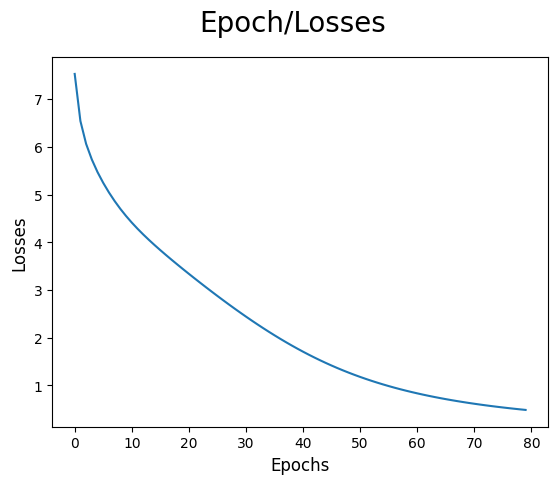

In [22]:
#Analyze
#Plot loss/epoch
ix = np.arange(0,80)
fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [23]:
#Predict function
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    return word

In [26]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])

'about'

In [28]:
def accuracy():
    wrong = 0
    for context, target in data:
        if(predict(context) != target):
            wrong += 1
    return (1 - (wrong / len(data)))

In [29]:
accuracy()

1.0

In [30]:
predict(['processes', 'manipulate', 'things', 'study'])

'abstract'